In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot(x, y, x_label=None, y_label=None, title=None, name_save_file=None, points=None):
    if title:
        plt.title(title)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    if points:
        for i in range(len(points)):
            plt.scatter(*points[i], c="green")
        plt.scatter(*points[i], c="green", label="полезная мутация")
        plt.legend()
    plt.plot(x, y)
    plt.grid()
    if name_save_file:
        plt.savefig(name_save_file)
    plt.show()

def calc_mutual_inductance(coil_1, coil_2, d, po=0, fi=0):
    mu0 = 4 * np.pi * 10 ** (-7)
    mutual_inductance = np.ones((len(coil_1), len(coil_2)))
    N = 90
    K = 90
    df1 = 2 * np.pi / N
    df2 = 2 * np.pi / K
    for ri in range(len(coil_1)):
        for rj in range(len(coil_2)):
            M = 0
            for n in range(N):
                for k in range(K):
                    xk_xn = po + coil_1[ri] * np.cos(df2 * k) * np.cos(fi) - coil_2[rj] * np.cos(df1 * n)
                    yk_yn = coil_1[ri] * np.sin(df2 * k) * np.cos(fi) - coil_2[rj] * np.sin(df1 * n)
                    zk_zn = d + coil_1[ri] * np.cos(df2 * k) * np.sin(fi)
                    r12 = (xk_xn ** 2 + yk_yn ** 2 + zk_zn ** 2) ** 0.5
                    M += (np.cos(df2 * k - df1 * n) * df1 * df2) / r12
            M *= mu0 * coil_1[ri] * coil_2[rj] / (4 * np.pi)
            mutual_inductance[ri][rj] = M
    return np.sum(mutual_inductance)

def calc_self_inductance(coil, thin=0.001):
    mu0 = 4 * np.pi * 10 ** (-7)
    L = np.sum(mu0 * coil * (np.log(8 * coil / thin) - 7 / 4 + (thin ** 2) / (8 * coil ** 2) * (np.log(8 * coil / thin) + 1 / 3)))
    mutual_inductance = np.ones((len(coil), len(coil)))
    N = 90
    K = 90
    df1 = 2 * np.pi / N
    df2 = 2 * np.pi / K
    d = 0
    po = 0
    fi = 0
    for ri in range(len(coil)):
        for rj in range(len(coil)):
            M = 0
            if ri != rj:
                for n in range(N):
                    for k in range(K):
                        xk_xn = po + coil[ri] * np.cos(df2 * k) * np.cos(fi) - coil[rj] * np.cos(df1 * n)
                        yk_yn = coil[ri] * np.sin(df2 * k) * np.cos(fi) - coil[rj] * np.sin(df1 * n)
                        zk_zn = d + coil[ri] * np.cos(df2 * k) * np.sin(fi)
                        r12 = (xk_xn ** 2 + yk_yn ** 2 + zk_zn ** 2) ** 0.5
                        M += (np.cos(df2 * k - df1 * n) * df1 * df2) / r12
                M *= mu0 * coil[ri] * coil[rj] / (4 * np.pi)
            mutual_inductance[ri][rj] = M
    M = np.sum(mutual_inductance)
    L += M
    return L

def calc_coupling_coefficient(coil_1, coil_2, d, po=0, fi=0):
    M = calc_mutual_inductance(coil_1, coil_2, d, po=po, fi=fi)
    L1 = calc_self_inductance(coil_1)
    L2 = calc_self_inductance(coil_2)
    k = M / (L1 * L2) ** 0.5
    return k

In [4]:
# катушка №1, параметры даны в метрах
coil_1 = np.array([0.028, 0.07])

# катушки, параметры даны в метрах
coils_r = np.array([0.4 * np.linspace(0.01, 0.1, 100)]).T
coils_l = np.array([np.linspace(0.01, 0.1, 100)]).T
coils = np.hstack([coils_r, coils_l])

# расстояние между катушками в метрах
d = 0.005

# толщина провода
thin = 0.001

In [5]:
# расчёт взаимной индуктивности между катушками
M = np.array([])
for coil in coils:
    M = np.append(M, calc_mutual_inductance(coil_1, coil, d))

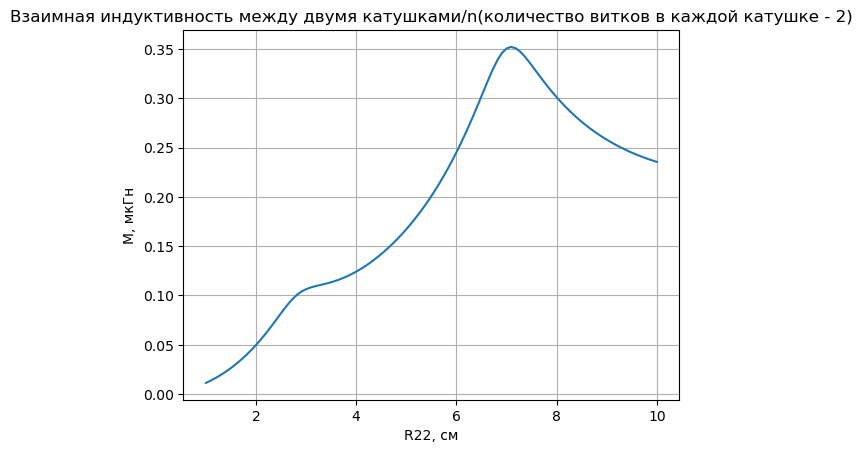

Mmax = 0.3520290137562214 мкГн при 7.090909090909092 см


In [6]:
# вывод графика взаимной индуктивности
plot(coils_l.T[0] * 10 ** 2, M * 10 ** 6, x_label="R22, cм", y_label="M, мкГн",
     title="Взаимная индуктивность между двумя катушками/n(количество витков в каждой катушке - 2)")

print(f"Mmax = {np.max(M) * 10 ** 6} мкГн при {coils_l[np.argmax(M)][0] * 10 ** 2} см")

In [7]:
# расчёт собственной индуктивности для первой катушки,толщина провода r_turn = 0,001 м
L1 = calc_self_inductance(coil_1, thin=0.001)

# расчёт собственной индуктивности для катушек,толщина провода r_turn = 0,001 м
k = np.array([])
for coil in coils:
    k = np.append(k, calc_coupling_coefficient(coil_1, coil, d))

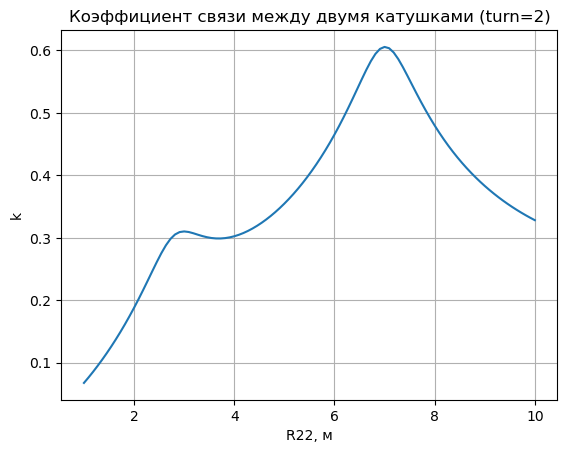

kmax = 0.605586651423285 при 7.000000000000001 см


In [8]:
# вывод графика коэф. связи между катушками
plot(coils_l.T[0] * 10 ** 2, k, x_label="R22, м", y_label="k", title="Коэффициент связи между двумя катушками (turn=2)")

print(f"kmax = {np.max(k)} при {coils_l[np.argmax(k)][0] * 10 ** 2} см")

## Применение "steepest ascent hill climbing algorithm" для оптимизации формы катушки ##

In [17]:
# steepest ascent hill climbing algorithm для поиска максимума функции
def mutation(start, finish, с, r=0.005):
    v = np.random.uniform(low=start if с[1] - r < start else с[1] - r,
                           high=finish if с[1] + r > finish else с[1] + r)
    return np.array([0.4 * v, v])

good_mutation = []
bad_mutation = []
all_mutation = []

init_v = np.random.uniform(0.01, 0.1) 
c2 = np.array([0.4 * init_v, init_v])
thr_k = 1e-4

while True:
    fit_k = calc_coupling_coefficient(coil_1, c2, d)
    c2_q = mutation(0.01, 0.1, c2)
    fit_kq = calc_coupling_coefficient(coil_1, c2_q, d)
    if fit_kq >= fit_k:
        good_mutation.append((c2_q[1], fit_kq))
        c2 = c2_q
        fit_k = fit_kq
    else:
        bad_mutation.append((c2[1], fit_kq))
    all_mutation.append((c2[1], fit_kq))
    if len(good_mutation) >= 2:
        if (good_mutation[-1][1] - good_mutation[-2][1]) / thr_k < 1:
            break

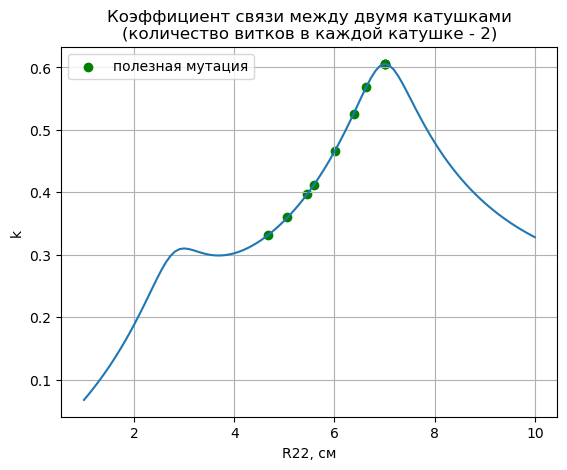

kmax = 0.6056125002891795; R2max = 0.07006759817603174 м
Количество полезных мутаций: 9
Количество вредных мутаций: 30
Всего мутаций: 39


In [18]:
plot(coils_l.T[0] * 10 ** 2, k, x_label="R22, cм", y_label="k",
     title="Коэффициент связи между двумя катушками\n(количество витков в каждой катушке - 2)", 
     points=[(m[0] * 10 ** 2, m[1])for m in good_mutation],
     name_save_file="hill_climbing_two_coils_N=2.png")

print(f"kmax = {fit_k}; R2max = {c2[1]} м")
print(f"Количество полезных мутаций: {len(good_mutation)}")
print(f"Количество вредных мутаций: {len(bad_mutation)}")
print(f"Всего мутаций: {len(all_mutation)}")